Enter your region to get started
Type in one of the following regions or else the program wont work correctly:

na1 or EUW 

Accuracy Scores:  [0.5, 0.65, 0.45, 0.55, 0.55, 0.45, 0.55, 0.45, 0.45, 0.65]
Average Accuracy Score:  0.5250000000000001


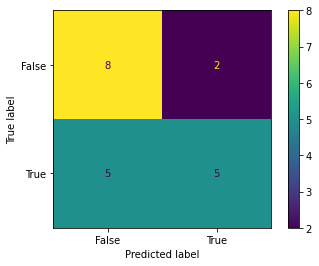

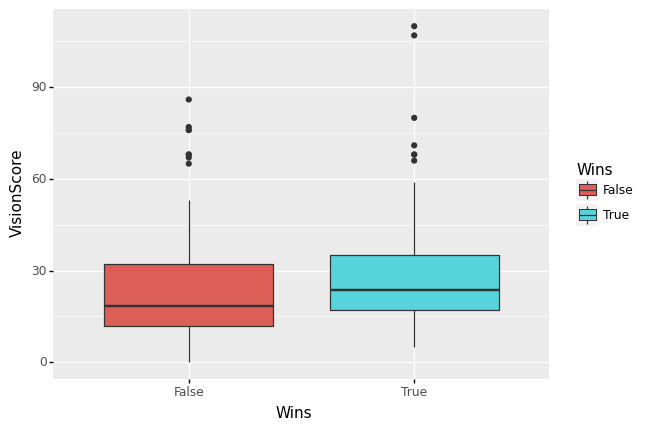

<ggplot: (301690481)>


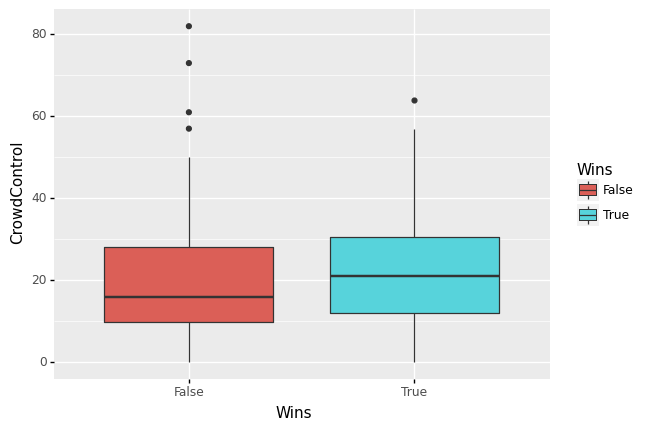

<ggplot: (301868734)>


In [5]:
import requests
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

VisionScores = []
WinLoss = []
CCstats = []
GameIDs = []
wins = []

matchesPulling = 20

def requestMatchData(region, matchID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/match/v4/matches/" + str(matchID) + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def requestSummonerData(region, summonerName, APIKey):

    #Create URL and return json file
    
    URL = "https://" + region + ".api.riotgames.com/lol/summoner/v4/summoners/by-name/" + summonerName + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def requestRankedData(region, ID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/league/v4/entries/by-summoner/" + ID + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()
    
def requestMatchHistory(region, ID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/match/v4/matchlists/by-account/" + ID + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def requestMatchData(region, matchID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/match/v4/matches/" + str(matchID) + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def matchIDs(JSON):
    numGames = JSON['endIndex']-JSON['startIndex']
    for x in range(numGames):
        GameIDs.append(JSON['matches'][x]['gameId'])
    return GameIDs

def returnScores(JSON):
    for x in range(10):
        result = JSON['participants'][x]['stats']['win']
        wins.append(result)
        
        if result == False:
            WinLoss.append(0)
        else:
            WinLoss.append(1)
        
        VisionScores.append(JSON['participants'][x]['stats']['visionScore'])
        CCstats.append(JSON['participants'][x]['stats']['timeCCingOthers'])

def main():
    print("Enter your region to get started")
    print("Type in one of the following regions or else the program wont work correctly:\n")
    print("na1 or EUW \n")

    #Ask the user for three things, their region, summoner name, and API Key.

    region = "na1"
    #region = (str)(input('Type in one of the regions above: '))
    summonerName = "OGPoonSlayer"
    #summonerName = (str)(input('Type your Summoner Name here and DO NOT INCLUDE ANY SPACES: '))
    APIKey = "RGAPI-659c5b06-188b-42e1-8d47-b7970b5d91ab"
    #APIKey = (str)(input('Copy and paste your API Key here: '))

    #Input variables into function
    responseJSON  = requestSummonerData(region, summonerName, APIKey)
    
    ID = str(responseJSON['name'])
    encID = str(responseJSON['id'])
    accID = str(responseJSON['accountId'])
    puuid = str(responseJSON['puuid'])
    
    responseJSON1 = requestMatchHistory(region, accID, APIKey)
    
    matchHistory = []
    
    matchHistory = matchIDs(responseJSON1)
    
    for x in range(matchesPulling):
        JSON = requestMatchData(region, matchHistory[x], APIKey)
        returnScores(JSON)
        
    df = pd.DataFrame({"VisionScore" : VisionScores, "CrowdControl" : CCstats, "Win" : WinLoss, "Wins" : wins})
    
    features = ["VisionScore","CrowdControl"]
    X = df[features]
    y = df[["Wins"]]
    acc1 = []
    logModel = LogisticRegression()

    z = StandardScaler()
    
    X[features] = z.fit_transform(X)
    
    kf = KFold(n_splits = 10)
    
    for train_indices, test_indices in kf.split(X):
        X_train = X.iloc[train_indices]
        X_test = X.iloc[test_indices]
        y_train = y.iloc[train_indices]
        y_test = y.iloc[test_indices]
    
        model = logModel.fit(X_train, y_train)
    
        acc1.append(accuracy_score(y_test, model.predict(X_test)))
        
    print("Accuracy Scores: ", acc1)
    print("Average Accuracy Score: ", sum(acc1)/len(acc1))
    plot_confusion_matrix(logModel, X_test, y_test)
    
    
    print((ggplot(df, aes(x = 'Wins', y = 'VisionScore', fill = 'Wins')) + geom_boxplot()))
    print((ggplot(df, aes(x = 'Wins', y = 'CrowdControl', fill = 'Wins')) + geom_boxplot()))
    
if __name__ == "__main__":
    main()



1. Can we predict who will win a game based on vision scores and crowd control?

I slightly changed the question from what it was orignially because the league point variable resets for every tier so it wouldn't be a variable. Instead I used vision score and crowd control which are varaibles which measure in match statistics. 

The graphs which I plotted show that both crowd control and vision score tend to be slightly higher for winning teams than losing teams. The boxplot for vision score has a bigger range for winning teams so I'd say it has more of an impact than crowd control in terms of winning a game. However, the accuracy score is around 50% and the confusion matrix points out some problems in my model. The predictive power is not very strong and judging from the graphs I think you can't predict who will win a game based off vision scores and crowd control. The difference between in vision score and crowd control is not significant when comparing losing and winning teams. 